# Initialisations

In [1]:
import pandas as pd ; pd.set_option('display.max_columns', None, 'display.max_rows', None)
pd.set_option('expand_frame_repr', True)
import numpy as np
import pubchempy as pcp
from rdkit import Chem
import cirpy #for changing between identifiers
import matplotlib.pyplot as plt
import seaborn as sns

#for web integration
from googlesearch import search
import webbrowser

#for molecular drawings and descriptor calculation
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import rdMolDescriptors as descriptor
from rdkit.Chem import Crippen
from rdkit.Chem import AllChem
#size = (120, 120)  # Smaller figures than the default.

from sklearn import linear_model
import statsmodels.api as sm

#for progress bars
from ipywidgets import widgets, Layout
from IPython.display import display
from ipywidgets import IntProgress 
#Run this part outside of the loop - create progress bar

#max_count = len(cal_df.index.values)
#f = IntProgress(min=0, max=max_count, description='CIDs') # instantiate the bar
#display(f) # display the bar
#count = 0
    
    
#Place this part inside the loop

    #f.value += 1 # signal to increment the progress bar
    #count += 1

Each constant is marked with a symbol denoting how the HLC was obtained
- Some values are calculated (T for thermo calc, Q for QSAR calc)
- Some values are estimates (E)
- Some values are probable incorrect (W)
- As stated above, some data was extrapolated to a different temperature or concentration range (R)

Here I will remove estimated/calculated values from the dataset

# Getting data from the supplement

In [2]:
file = open("henry_law_dataset/output/HcpSI.f90", "r")
species_f90 = (file.read().split(sep="! species:")) # create list where each element contains one species
species_list = [] 
constant_list_noVPAS = []
constant_list_VPAS = []
cas_list = []

for i in species_f90[1:]: #first line is ! alpha, skip this line with [1:]
    cas_line = i.split(sep='\n')[3] # fourth line contains CAS number
    cas_list.append(cas_line.split(sep='! casrn:   ')[1]) # isolate CAS number and place it in the list
    
    species = i.split(sep='\n')[0] #first line contains species name
    species_list.append(species[1:]) # isolate species name and place it in list
    hcpsi_lines = (i.split(sep='\n')[5:]) #lines past the 6th contain constants
    # each species has a different number of constants
    # loop through them and pull the constant from each line, place them into a list
    const_per_line_VPAS = []
    const_per_line_noVPAS = [] #list for each species' constants
    for j in range(0, len(hcpsi_lines)):
        if 'HcpSI' in hcpsi_lines[j]: #check if line contains constant
            const_type = hcpsi_lines[j].split(sep='type: ')[1].split(sep=',')[0] # isolate 'type' code
            if (const_type != 'W') and (const_type != 'E') and (const_type != 'T') and (const_type != 'Q') and (const_type != 'V'):
                # remove calculated / incorrect constants
                const_per_line_noVPAS.append(hcpsi_lines[j].split(sep='=  ')[1][0:8]) # add remaining constants to list
            if (const_type != 'W') and (const_type != 'E') and (const_type != 'T') and (const_type != 'Q'):
                const_per_line_VPAS.append(hcpsi_lines[j].split(sep='=  ')[1][0:8]) # add remaining constants to list
        else:
            pass
    
    if 'HcpSI' in i:
        new_value_list_noVPAS = []
        for const in const_per_line_noVPAS:
            # convert constants from strings to floats
            if type(const) == str:
                number = float(const.split(sep='E')[0])
                power = float((const.split(sep='E')[1]))
                new_value = (number*np.power(10, power)) # create float
                log_value = np.log(1/new_value) # inverse of H gives Kh, then take log.
            new_value_list_noVPAS.append(log_value) # put new value into list per species
        constant_list_noVPAS.append(new_value_list_noVPAS) # put new lists into final list of constant lists
    else:
        constant_list_noVPAS.append(np.nan)

    if 'HcpSI' in i:
        new_value_list_VPAS = []
        for const in const_per_line_VPAS:
            # convert constants from strings to floats
            if type(const) == str:
                number = float(const.split(sep='E')[0])
                power = float((const.split(sep='E')[1]))
                new_value = (number*np.power(10, power)) # create float
                log_value = np.log(1/new_value) # inverse of H gives Kh, then take log.
            new_value_list_VPAS.append(log_value) # put new value into list per species
        constant_list_VPAS.append(new_value_list_VPAS) # put new lists into final list of constant lists
    else:
        constant_list_VPAS.append(np.nan)
        
print("noVPAS", len(cas_list), len(species_list), len(constant_list_noVPAS), '\n',
     type(cas_list), type(species_list), type(constant_list_noVPAS), '\n',
     type(cas_list[0]), type(species_list[0]), type(constant_list_noVPAS[0])) #checking lists are full and correct type
print("VPAS", len(cas_list), len(species_list), len(constant_list_VPAS), '\n',
     type(cas_list), type(species_list), type(constant_list_VPAS), '\n',
     type(cas_list[0]), type(species_list[0]), type(constant_list_VPAS[0])) #checking lists are full and correct type

noVPAS 4632 4632 4632 
 <class 'list'> <class 'list'> <class 'list'> 
 <class 'str'> <class 'str'> <class 'list'>
VPAS 4632 4632 4632 
 <class 'list'> <class 'list'> <class 'list'> 
 <class 'str'> <class 'str'> <class 'list'>


# Conversion of CAS numbers to SMILES strings

In [6]:
smiles_list = []

max_count = len(cas_list)
f = IntProgress(min=0, max=max_count, description='CAS->SMILES') # instantiate the bar
display(f) # display the bar
count = 0
    
for cas in cas_list:
    smiles_list.append(cirpy.resolve(cas, 'smiles')) #convert CAS to SMILES
    f.value += 1 # signal to increment the progress bar
    count += 1

IntProgress(value=0, description='CAS->SMILES', max=4632)

In [25]:
for dataset in ['VPAS', 'noVPAS']:
    constant_list = eval('constant_list_%s'%dataset)
    min_list = []; max_list = []; mean_list = []; median_list = []; num_constants_list = []
    for clist in constant_list:
        if (type(clist) == list):
            if (len(clist) != 0):
                #get various stats for each species' constants
                min_list.append(np.min(clist))
                max_list.append(np.max(clist))
                mean_list.append(np.mean(clist))
                median_list.append(np.median(clist))
            else:
                min_list.append(0)
                max_list.append(0)
                mean_list.append(0)
                median_list.append(0)
        else:
            min_list.append(0)
            max_list.append(0)
            mean_list.append(0)
            median_list.append(0)
        if type(clist) == list:
            num_constants_list.append(len(clist))
        else:
            num_constants_list.append(0)
    const_list_df = pd.DataFrame(species_list)
    const_list_df.rename({0:'Species'}, axis=1, inplace=True)
    const_list_df['Num'] = num_constants_list
    const_list_df['min'] = min_list    
    const_list_df['max'] = max_list    
    const_list_df['mean'] = mean_list    
    const_list_df['median'] = median_list
    const_list_df['max-min'] = np.array(max_list) - np.array(min_list)
    const_list_df.set_index('Species', inplace=True)
    exec('const_list_df_%s = const_list_df'%dataset)

# Visualise data distribution, look at varying constants

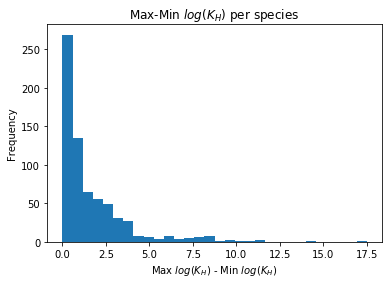

In [28]:
plt.hist(const_list_df[const_list_df_noVPAS['max-min']!=0]['max-min'], bins=30)
plt.title('Max-Min $log(K_H)$ per species')
plt.xlabel('Max $log(K_H)$ - Min $log(K_H)$')
plt.ylabel('Frequency')
hist = plt.gcf()

hist.savefig('range_per_species.png')

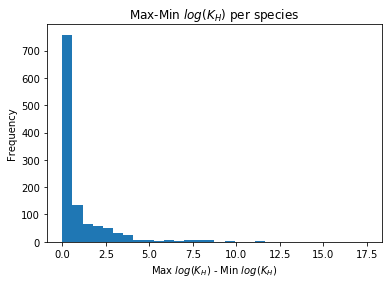

In [29]:
plt.hist(const_list_df[const_list_df_VPAS['max-min']!=0]['max-min'], bins=30)
plt.title('Max-Min $log(K_H)$ per species')
plt.xlabel('Max $log(K_H)$ - Min $log(K_H)$')
plt.ylabel('Frequency')
hist = plt.gcf()

hist.savefig('range_per_species.png')

In [36]:
for dataset in ['VPAS', 'noVPAS']:
    print(dataset)
    display(eval('const_list_df_%s[const_list_df_%s["max-min"] > 15]'%(dataset, dataset))) #these vary by more than 15 log units
    num_species = 0
    for num in range(0, 100):
        if len(const_list_df[const_list_df['Num'] == num] != 0):
            print(len(const_list_df[const_list_df['Num'] == num]), "species with %i constant(s)" % num)
        num_species += len(const_list_df[const_list_df['Num'] == num])
    if num_species == len(const_list_df):
        print("This accounts for all species")
    else:
        print("Not all species accounted for - there are %i species missing from this count" % (len(const_list_df) - num_species))

VPAS


,Num,min,max,mean,median,max-min
Species,,,,,,
hexanedioic acid,4,-18.005165,-2.397895,-11.765305,-13.329080,15.607270
"(2,4-dichlorophenoxy)-ethanoic acid",11,-15.520259,1.966113,-6.163701,-6.877296,17.486372
pebulate,4,-23.858760,3.194183,-4.310896,1.710496,27.052943
iodofenphos,2,-23.858760,-0.788457,-12.323609,-12.323609,23.070303


3018 species with 0 constant(s)
852 species with 1 constant(s)
267 species with 2 constant(s)
113 species with 3 constant(s)
85 species with 4 constant(s)
65 species with 5 constant(s)
38 species with 6 constant(s)
26 species with 7 constant(s)
21 species with 8 constant(s)
24 species with 9 constant(s)
22 species with 10 constant(s)
12 species with 11 constant(s)
10 species with 12 constant(s)
6 species with 13 constant(s)
9 species with 14 constant(s)
4 species with 15 constant(s)
6 species with 16 constant(s)
7 species with 17 constant(s)
3 species with 18 constant(s)
4 species with 19 constant(s)
5 species with 20 constant(s)
3 species with 21 constant(s)
1 species with 22 constant(s)
5 species with 23 constant(s)
5 species with 24 constant(s)
2 species with 25 constant(s)
2 species with 26 constant(s)
1 species with 28 constant(s)
3 species with 29 constant(s)
1 species with 37 constant(s)
1 species with 39 constant(s)
2 species with 40 constant(s)
2 species with 42 constant(s)
1 

,Num,min,max,mean,median,max-min
Species,,,,,,
"(2,4-dichlorophenoxy)-ethanoic acid",5,-15.520259,1.966113,-6.359637,-6.877296,17.486372


3018 species with 0 constant(s)
852 species with 1 constant(s)
267 species with 2 constant(s)
113 species with 3 constant(s)
85 species with 4 constant(s)
65 species with 5 constant(s)
38 species with 6 constant(s)
26 species with 7 constant(s)
21 species with 8 constant(s)
24 species with 9 constant(s)
22 species with 10 constant(s)
12 species with 11 constant(s)
10 species with 12 constant(s)
6 species with 13 constant(s)
9 species with 14 constant(s)
4 species with 15 constant(s)
6 species with 16 constant(s)
7 species with 17 constant(s)
3 species with 18 constant(s)
4 species with 19 constant(s)
5 species with 20 constant(s)
3 species with 21 constant(s)
1 species with 22 constant(s)
5 species with 23 constant(s)
5 species with 24 constant(s)
2 species with 25 constant(s)
2 species with 26 constant(s)
1 species with 28 constant(s)
3 species with 29 constant(s)
1 species with 37 constant(s)
1 species with 39 constant(s)
2 species with 40 constant(s)
2 species with 42 constant(s)
1 

# Marking species with varying HLCs
One-hot encoding to mark these species - not to be used as a feature to train models with.

In [56]:
for dataset in ['VPAS', 'noVPAS']:
    const_list_df = eval('const_list_df_%s'%dataset)
    for vary_by in range(0, 10):
        exec('vary_list_%s_%s = []'% (str(vary_by), dataset)) # create many empty lists at once
        for i in range(0, len(eval('const_list_df_%s'%dataset))):
            exec('max_min = const_list_df_%s.iloc[i]["max-min"]'%dataset)
            # one hot encoding - for vary_list_x, append 1 if range is larger than x and 0 if not
            if max_min > vary_by:
                exec('vary_list_%i_%s.append(1)'%(vary_by, dataset))
            else:
                exec('vary_list_%i_%s.append(0)'%(vary_by, dataset))
        exec('print("vary_list_%i_%s", len(vary_list_%i_%s), "constants total.", vary_list_%i_%s.count(1), "varying constants")'
             %(vary_by, dataset, vary_by, dataset, vary_by, dataset)) #ensure all constants are processed properly

vary_list_0_VPAS 4632 constants total. 1179 varying constants
vary_list_1_VPAS 4632 constants total. 665 varying constants
vary_list_2_VPAS 4632 constants total. 465 varying constants
vary_list_3_VPAS 4632 constants total. 296 varying constants
vary_list_4_VPAS 4632 constants total. 182 varying constants
vary_list_5_VPAS 4632 constants total. 110 varying constants
vary_list_6_VPAS 4632 constants total. 82 varying constants
vary_list_7_VPAS 4632 constants total. 60 varying constants
vary_list_8_VPAS 4632 constants total. 40 varying constants
vary_list_9_VPAS 4632 constants total. 29 varying constants
vary_list_0_noVPAS 4632 constants total. 687 varying constants
vary_list_1_noVPAS 4632 constants total. 318 varying constants
vary_list_2_noVPAS 4632 constants total. 200 varying constants
vary_list_3_noVPAS 4632 constants total. 110 varying constants
vary_list_4_noVPAS 4632 constants total. 60 varying constants
vary_list_5_noVPAS 4632 constants total. 44 varying constants
vary_list_6_noVPA

# Picking constants to use for each species
Henry's Law constants vary by a fair amount - values between species can differ by orders of magnitude. Perhaps its an idea to take the log of the constants as we get them and then work out how to split from there?
> Changed the code in `Getting data from the supplement` to use the log value from the start

Now to figure out which values to use. I think a difference of one log unit is a reasonable threshold to drop, but will check this with Jeremy.

> For now, I will not drop any constants, and will instead use the mean for each species.

I'm going to create several columns in this dataframe - each holding a different choice of constant.

In [71]:
len(constant_list_VPAS)

4632

In [72]:
for dataset in ['VPAS', 'noVPAS']:
    exec('mean_constant_list_%s = []'%dataset) #take mean for each list of constants
    for i in range(0, len(eval('constant_list_%s'%dataset))):
        if type(constant_list[i]) == list:
            eval('mean_constant_list_%s.append(np.mean(constant_list_%s[i]))'%(dataset, dataset))
        else:
            eval('mean_constant_list_%s.append(np.nan)'%dataset)

    exec('first_constant_list_%s = []'%dataset) #use first constant in each case
    for i in range(0, len(eval('constant_list_%s'%dataset))):
        if type(eval('constant_list_%s'%dataset)[i]) == list:
            if len(eval('constant_list_%s'%dataset)[i]) > 0:
                eval('first_constant_list_%s.append(np.mean(constant_list_%s[i]))'%(dataset, dataset))
            else:
                eval('first_constant_list_%s.append(np.nan)'%dataset)
        else:
            eval('first_constant_list_%s.append(np.nan)'%dataset)

C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [73]:
len(first_constant_list_VPAS)

4632

# Construct dataframe of SMILES, names and constants for all species

In [4]:
if not 'smiles_list' in dir():
    smiles_list = pd.read_csv('../smiles_constants.csv').iloc[:, 2] #already constructed smiles list from CAS numbers
smiles_list[0:10]

0         O=O
1     O=[O]=O
2      [H][H]
3         [H]
4    [2H][2H]
5       [OH-]
6       O[O-]
7          OO
8         N#N
9           N
Name: 1, dtype: object

In [88]:
for dataset in ['VPAS', 'noVPAS']:
    smiles_constant_species = pd.concat([pd.Series(species_list), #creating dataframe to hold all info found so far
                                         pd.Series(smiles_list),
                                         pd.Series(eval('mean_constant_list_%s'%dataset)), #kept first Kh and mean in each case
                                         pd.Series(eval('first_constant_list_%s'%dataset)), #will train on both sets and see which is better
                                        pd.Series(eval('vary_list_1_%s'%dataset)), #one-hot encoded variation in constants
                                        pd.Series(eval('vary_list_2_%s'%dataset)), #to be used for highlighting after training
                                        pd.Series(eval('vary_list_3_%s'%dataset)), # /not/ to be used as a feature
                                        pd.Series(eval('vary_list_4_%s'%dataset)), #perhaps could be used to weight certain species?
                                        pd.Series(eval('vary_list_5_%s'%dataset)),
                                        pd.Series(eval('vary_list_6_%s'%dataset)),
                                        pd.Series(eval('vary_list_7_%s'%dataset)),
                                        pd.Series(eval('vary_list_8_%s'%dataset)),
                                        pd.Series(eval('vary_list_9_%s'%dataset))],
                                        axis=1)
    smiles_constant_species.to_csv('smiles_constants_kh_noVPAS.csv') #export so all the work isn't lost
    smiles_constant_species.set_index(0, inplace=True)
    smiles_constant_species.rename({0+1:'SMILES', 1+1:'Kh_mean', 2+1:'Kh_first', 3+1:'Varying_1',
                                   4+1:'Varying_2', 5+1:'Varying_3', 6+1:'Varying_4', 7+1:'Varying_5',
                                   8+1:'Varying_6', 9+1:'Varying_7', 10+1:'Varying_8', 11+1:'Varying_9'}, axis=1, inplace=True)
    exec('smiles_constant_species_%s = smiles_constant_species'%dataset)

In [90]:
smiles_constant_species_VPAS.head()

,SMILES,Kh_mean,Kh_first,Varying_1,Varying_2,Varying_3,Varying_4,Varying_5,Varying_6,Varying_7,Varying_8,Varying_9
0,,,,,,,,,,,,
oxygen,O=O,11.267713,11.267713,0,0,0,0,0,0,0,0,0
ozone,O=[O]=O,9.508258,9.508258,1,1,1,1,0,0,0,0,0
hydrogen atom,[H][H],12.859999,12.859999,0,0,0,0,0,0,0,0,0
hydrogen,[H],11.768784,11.768784,0,0,0,0,0,0,0,0,0
deuterium,[2H][2H],11.748648,11.748648,0,0,0,0,0,0,0,0,0


# Dropping species with no experimental constants

In [97]:
for dataset in ['VPAS', 'noVPAS']:
    print('Species to drop in %s data: '%dataset, len(eval('const_list_df_%s[const_list_df_%s["Num"] == 0]'%(dataset, dataset))))
    no_constants = eval('const_list_df_%s[const_list_df_%s["Num"] == 0]'%(dataset, dataset))
    exec('to_drop_%s = list(no_constants.index.values)'%dataset)
    constants = eval('const_list_df_%s[const_list_df_%s["Num"] != 0]'%(dataset, dataset))
    exec('to_keep_%s = list(constants.index.values)'%dataset)

Species to drop in VPAS data:  2100
Species to drop in noVPAS data:  3018


In [98]:
for dataset in ['VPAS', 'noVPAS']:
    
    exec('filtered_smiles_constant_species_%s = smiles_constant_species_%s.loc[to_keep_%s]'%(dataset, dataset, dataset))
    eval('filtered_smiles_constant_species_%s.rename({1:"SMILES", 2:"Constant", 3:"Varying"}, axis=1, inplace=True)'%dataset)
    display(eval('filtered_smiles_constant_species_%s.head()'%dataset))

,SMILES,Kh_mean,Kh_first,Varying_1,Varying_2,Varying_3,Varying_4,Varying_5,Varying_6,Varying_7,Varying_8,Varying_9
0,,,,,,,,,,,,
oxygen,O=O,11.267713,11.267713,0,0,0,0,0,0,0,0,0
ozone,O=[O]=O,9.508258,9.508258,1,1,1,1,0,0,0,0,0
hydrogen atom,[H][H],12.859999,12.859999,0,0,0,0,0,0,0,0,0
hydrogen,[H],11.768784,11.768784,0,0,0,0,0,0,0,0,0
deuterium,[2H][2H],11.748648,11.748648,0,0,0,0,0,0,0,0,0


,SMILES,Kh_mean,Kh_first,Varying_1,Varying_2,Varying_3,Varying_4,Varying_5,Varying_6,Varying_7,Varying_8,Varying_9
0,,,,,,,,,,,,
oxygen,O=O,11.267713,11.267713,0,0,0,0,0,0,0,0,0
ozone,O=[O]=O,9.508258,9.508258,1,1,1,1,0,0,0,0,0
hydrogen atom,[H][H],12.859999,12.859999,0,0,0,0,0,0,0,0,0
hydrogen,[H],11.768784,11.768784,0,0,0,0,0,0,0,0,0
deuterium,[2H][2H],11.748648,11.748648,0,0,0,0,0,0,0,0,0


# Organic/inorganic split

In [99]:
for dataset in ['VPAS', 'noVPAS']:
    exec('carbons_list_%s = [] ; no_carbons_list_%s = []'%(dataset, dataset))
    for i in range(0, len(eval('filtered_smiles_constant_species_%s'%dataset))):
        smiles = eval('filtered_smiles_constant_species_%s.SMILES.iloc[i]'%dataset)
        try:
            mol = Chem.MolFromSmiles(smiles) # create rdkit mol object
            smarts = Chem.MolToSmarts(mol) # use mol object to create SMARTS
        except:
            smarts = 'x' #mark failed species in the list
        name = eval('filtered_smiles_constant_species_%s.index[i]'%dataset)
        if type(smarts) == str:
            if '#6' in smarts:
                eval('carbons_list_%s.append(i)'%dataset) # RDKit SMARTS strings work by atomic number (hence carbon = #6)
            else:
                eval('no_carbons_list_%s.append(i)'%dataset) # append non-carbon-containing species to a seperate list

In [105]:
organics_VPAS = filtered_smiles_constant_species_VPAS.iloc[carbons_list_VPAS] # new df containing carbon compounds only
organics_noVPAS = filtered_smiles_constant_species_noVPAS.iloc[carbons_list_noVPAS] # new df containing carbon compounds only

# Removing metal-containing species

In [108]:
for dataset in ['VPAS', 'noVPAS']:
    drop_list = []
    # removing metals using list of common metals.
    # aniline compound at beginnning contains (corrupted?) SMILES string full of tungsten.
    metals_removal_list = ["4,4',4''-methanetriyltris(N,N-diethylaniline)", 'Hg', 'Se', 'As', 'Zn', 'Si', 'Na', 'Al', 'Pb', 'Sn']
    for i in range(0, len(eval('organics_%s'%dataset))):
        for metal in metals_removal_list:
            if metal in eval('organics_%s.SMILES[i]'%dataset):
                drop_list.append(eval('organics_%s.index[i]'%dataset))
                #create drop list in loop, then remove all metal-containing species at once

    eval('organics_%s.drop(labels=drop_list, inplace=True, axis=0)'%dataset)

C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


# Export organics as csv

In [111]:
organics_VPAS.to_csv('organics_constants_VPAS.csv')
organics_noVPAS.to_csv('organics_constants_noVPAS.csv')

# Create RDKit descriptors

In [114]:
def try_func(list_name, function, mol):
    """Tries function on an rdkit mol object; if function throws error then np.nan
    is appended to the list - if the function succeeds then the output is appended"""
    try:    
        var = (function(mol))
        list_name.append(var)
    except:
        list_name.append(np.nan)

In [115]:
for dataset in ['VPAS', 'noVPAS']:
    wt_list = [] ; logp_list = [] ; fraction_sp3_list = []
    ali_homo_rings_list = [] ; ali_hetero_rings_list = [] 
    aro_homo_rings_list = [] ; aro_hetero_rings_list = []
    amide_bonds_list = [] ; hba_list = [] ; hbd_list = []
    tpsa_list = []

    for i in range(0, len(eval('organics_%s'%dataset))):
        exec('smiles = (organics_%s.SMILES[i])'%dataset)
        try:
            mol = Chem.AddHs(Chem.MolFromSmiles(smiles))
        except Exception as e:
            pass


        if type(mol) != str and type(mol) != None:
            try_func(wt_list, descriptor.CalcExactMolWt, mol)
            try_func(logp_list, Crippen.MolLogP, mol)
            try_func(fraction_sp3_list, descriptor.CalcFractionCSP3, mol)
            try_func(ali_homo_rings_list, descriptor.CalcNumAliphaticCarbocycles, mol)
            try_func(ali_hetero_rings_list, descriptor.CalcNumAliphaticHeterocycles, mol)
            try_func(aro_homo_rings_list, descriptor.CalcNumAromaticCarbocycles, mol)
            try_func(aro_hetero_rings_list, descriptor.CalcNumAromaticHeterocycles, mol)
            try_func(amide_bonds_list, descriptor.CalcNumAmideBonds, mol)
            try_func(hba_list, descriptor.CalcNumHBA, mol)
            try_func(hbd_list, descriptor.CalcNumHBD, mol)
            try_func(tpsa_list, descriptor.CalcTPSA, mol)

    exec("organics_%s['wt'] = wt_list"%dataset)
    exec("organics_%s['logp'] = logp_list"%dataset)
    exec("organics_%s['fraction_sp3'] = fraction_sp3_list"%dataset)
    exec("organics_%s['ali_homo_rings'] = ali_homo_rings_list"%dataset)
    exec("organics_%s['ali_hetero_rings'] = ali_hetero_rings_list"%dataset)
    exec("organics_%s['amide_bonds'] = amide_bonds_list"%dataset)
    exec("organics_%s['aro_homo_rings'] = aro_homo_rings_list"%dataset)
    exec("organics_%s['aro_hetero_rings'] = aro_hetero_rings_list"%dataset)
    exec("organics_%s['hba'] = hba_list"%dataset)
    exec("organics_%s['hbd'] = hbd_list"%dataset)
    exec("organics_%s['tpsa'] = tpsa_list"%dataset)

C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [123]:
for dataset in ['VPAS', 'noVPAS']:
    asph_list = [] ; ecce_list = [] ; isf_list = [] ; npr1_list = [] ; npr2_list = [] 
    pmi1_list = [] ; pmi2_list = [] ; pmi3_list = [] ; rog_list = [] ; si_list = [] 


    max_count = len(eval('organics_%s'%dataset))
    f = IntProgress(min=0, max=max_count, description='Progress') # instantiate the bar
    display(f) # display the bar
    count = 0


    #Place this part inside the loop


    from rdkit.Chem import Descriptors3D

    for i in range(0, len(eval('organics_%s'%dataset))):
        exec('smiles = (organics_%s.SMILES[i])'%dataset)
        try:
            mol = Chem.AddHs(Chem.MolFromSmiles(smiles))
            AllChem.EmbedMolecule(mol) #embed to calc 3D descriptors
            Chem.rdForceFieldHelpers.MMFFOptimizeMolecule(mol) #optimize
        except Exception as e:
            mol=None
        try_func(asph_list, Descriptors3D.Asphericity, mol)
        try_func(ecce_list, Descriptors3D.Eccentricity, mol)
        try_func(isf_list, Descriptors3D.InertialShapeFactor, mol)
        try_func(npr1_list, Descriptors3D.NPR1, mol)
        try_func(npr2_list, Descriptors3D.NPR2, mol)
        try_func(pmi1_list, Descriptors3D.PMI1, mol)
        try_func(pmi2_list, Descriptors3D.PMI2, mol)
        try_func(pmi3_list, Descriptors3D.PMI3, mol)
        try_func(rog_list, Descriptors3D.RadiusOfGyration, mol)
        try_func(si_list, Descriptors3D.SpherocityIndex, mol)
        f.value += 1 # signal to increment the progress bar
        count += 1

    exec("organics_%s['asph'] = asph_list"%dataset)
    exec("organics_%s['ecce'] = ecce_list"%dataset)
    exec("organics_%s['isf'] = isf_list"%dataset)
    exec("organics_%s['npr1'] = npr1_list"%dataset)
    exec("organics_%s['npr2'] = npr2_list"%dataset)
    exec("organics_%s['pmi1'] = pmi1_list"%dataset)
    exec("organics_%s['pmi2'] = pmi2_list"%dataset)
    exec("organics_%s['pmi3'] = pmi3_list"%dataset)
    exec("organics_%s['rog'] = rog_list"%dataset)
    exec("organics_%s['si'] = si_list"%dataset)

IntProgress(value=0, description='Progress', max=2196)

C:\Users\jtd1g16\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


IntProgress(value=0, description='Progress', max=1404)

In [126]:
organics_VPAS.to_csv('rdkit_desc_VPAS.csv')
organics_noVPAS.to_csv('rdkit_desc_noVPAS.csv')